In [1]:
import os

# takes care of annoying TF-GPU warnings
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# remove useless Tensorflow warning:
# WARNING:absl:Found untraced functions such as _update_step_xla, lstm_cell_1_layer_call_fn, 
# lstm_cell_1_layer_call_and_return_conditional_losses, lstm_cell_2_layer_call_fn, 
# lstm_cell_2_layer_call_and_return_conditional_losses while saving (showing 5 of 5). 
# These functions will not be directly callable after loading.
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [2]:
# very useful for managing wandb runs: https://stackoverflow.com/questions/71106179/log-two-model-runs-with-keras-wandb
import wandb
from wandb.keras import WandbCallback
os.environ["WANDB_SILENT"] = "true"

#### RNN: Formula Label Prediction 

In [3]:
import numpy as np 
import pandas as pd
from pathlib import Path 

import tensorflow as tf

from tensorflow.keras import layers 
from tensorflow.keras import utils

import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import datetime

tfds.disable_progress_bar()
wandb_project_name = "binary_formula_classification"

In [4]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_"+metric], "")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_"+metric])

#### Import Data and Preprocess Dataframe

In [5]:
def preprocess_data(corpus,
                    irrelevant_features=["mtype",]):
    # drop irrelevant columns
    corpus.drop(irrelevant_features, inplace=True, axis=1)

    # filter strings
    def process_cell(cell_str):
        stripped_f_str = cell_str[1:-1].replace("\\\\", "\\")
        f_list = stripped_f_str.split(",")
        f_list = [token.replace("'", "").replace(" ", "") for token in f_list]
        f_list = ["{" if token == "\\{" else token for token in f_list]
        f_list = ["}" if token == "\\}" else token for token in f_list]
        cell_str = " ".join(f_list)
        return cell_str

    corpus["tokens"] = corpus["tokens"].map(process_cell)

In [6]:
#print(os.getcwd())
data_p = Path("../data/") / "bin_class_data_TOKENIZED_SET_V1.csv"
data = pd.read_csv(data_p)
preprocess_data(data)
data.head()


,tokens,type_tokens,label
0,f : A \to B,"['func_def', 'func_name', '__ANON_1', 'COLON',...",1
1,f,"['func_name', '__ANON_1']",1
2,g \colon B \to I,"['func_def', 'func_name', '__ANON_1', 'COLON',...",1
3,\frac { 8 ! } { ( 8 - 4 ) ! },"['expr_atom', 'CMD_FRAC', 'L_BRACE', 'postfix'...",1
4,f,"['func_name', '__ANON_1']",1


In [7]:
SIZE_TRAIN_DS = 10000
SIZE_TEST_DS = 1000
data_as_ds = tf.data.Dataset.from_tensor_slices((data["tokens"], data["label"])) 
test_dataset = data_as_ds.take(SIZE_TEST_DS)
train_dataset = data_as_ds.skip(SIZE_TEST_DS)

##### Setup and Data Preparation

In [8]:
for example, label in train_dataset.take(1):
    print("text: ", example.numpy())
    print("label: ", label.numpy())

text:  b'f'
label:  1


In [9]:
BUFFER_SIZE = SIZE_TRAIN_DS
BATCH_SIZE = 64
STEPS_PER_EPOCH = np.floor(SIZE_TRAIN_DS/BATCH_SIZE)
VAL_STEPS_PER_EPOCH = np.floor(SIZE_TEST_DS/BATCH_SIZE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

##### Text Encoding

In [10]:
def create_encoder(output_mode_str, n_grams):
    VOCAB_SIZE = 1000
    encoder = tf.keras.layers.TextVectorization(
        standardize=None,
        output_mode=output_mode_str,
        ngrams = n_grams,
        split="whitespace",
        max_tokens=VOCAB_SIZE)
    encoder.adapt(train_dataset.map(lambda tokens, label: tokens)) # removes the label column through transformation: text, label -> text
    return encoder

##### Representation 1: Use integer indices encoding

In [11]:
encoder_int = create_encoder("int", None)
vocab = np.array(encoder_int.get_vocabulary())
vocab[:200]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


array(['', '[UNK]', 'f', '1', '2', 'x', '}', '{', ':', '^', '(', ')', '0',
       '\\to', '+', '3', 'A', '-', 'g', 'n', 'B', '4', 'a', 'X', '=', '5',
       '\\rightarrow', 'b', '6', 'Y', '7', '\\frac', '\\mathbb', '9',
       '\\mathbb{N}', '\\mathbb{R}', 'h', '8', 'y', 'R', '\\colon', 'N',
       'S', 'c', 'F', '\\times', 'p', 'k', 'm', '/', 'C', 't', 'i', 'd',
       'z', 'e', 's', ']', '[', 'q', '\\mathbb{Z}', '\\cup', 'mathbb{N',
       '\\cap', 'r', '\\cdot', 'T', '\\dfrac', '\\circ', 'P', '!', 'D',
       'Z', 'varnothin', 'u', 'I', 'G', 'Q', 'co', 'E', 'M',
       '\\mathbb{Q}', 'mathbb{R', 'U', 'si', '*', 'mathbb{Z', 'j', 'V',
       'H', 'v', 'W', 'o', 'l', '\\varnothing)', 'Token(sets__SET_EMPTY',
       'w', 'K', 'mathbb{Q', 'L', 'arcta', '\\mathbb{C}', 'ta', 'arcsi',
       'J', '\\varnothing', '\\binom', 'lo', 'ex', 'O', 'arcco', '\\sin',
       '\\exp', 'sin', '\\tfrac', '\\tanh', '\\cos', 'mathbb{C',
       'mathbb{A', 'cos', '\\sec', '\\arctan', '\\arcsin'], dtype='<U2

In [12]:
encoded_example = encoder_int(example).numpy()
print(example)
print(encoded_example)

tf.Tensor(b'f', shape=(), dtype=string)
[2]


In [13]:
print("Original: ", example.numpy())
print("After reverse lookup: ", " ".join(vocab[encoded_example]))

Original:  b'f'
After reverse lookup:  f


##### Representation 2: Binary Count Vectorizer

In [14]:
encoder_multi_hot = create_encoder("multi_hot", None)
vocab = np.array(encoder_multi_hot.get_vocabulary())
vocab[:200]

array(['[UNK]', 'f', '1', '2', 'x', '}', '{', ':', '^', '(', ')', '0',
       '\\to', '+', '3', 'A', '-', 'g', 'n', 'B', '4', 'a', 'X', '=', '5',
       '\\rightarrow', 'b', '6', 'Y', '7', '\\frac', '\\mathbb', '9',
       '\\mathbb{N}', '\\mathbb{R}', 'h', '8', 'y', 'R', '\\colon', 'N',
       'S', 'c', 'F', '\\times', 'p', 'k', 'm', '/', 'C', 't', 'i', 'd',
       'z', 'e', 's', ']', '[', 'q', '\\mathbb{Z}', '\\cup', 'mathbb{N',
       '\\cap', 'r', '\\cdot', 'T', '\\dfrac', '!', '\\circ', 'P', 'D',
       'Z', 'varnothin', 'u', 'I', 'G', 'Q', 'co', 'E', 'M',
       '\\mathbb{Q}', 'si', 'mathbb{R', 'U', '*', 'mathbb{Z', 'j', 'V',
       'H', 'v', 'W', 'o', 'l', '\\varnothing)', 'Token(sets__SET_EMPTY',
       'w', 'K', 'mathbb{Q', 'L', 'arcta', '\\mathbb{C}', 'ta', 'arcsi',
       'J', '\\varnothing', '\\binom', 'lo', 'ex', 'O', 'arcco', '\\sin',
       '\\exp', 'sin', '\\tfrac', '\\tanh', '\\cos', 'mathbb{C',
       'mathbb{A', 'cos', '\\sec', '\\arctan', '\\arcsin'], dtype='<U21')

In [15]:
encoded_example = encoder_multi_hot(example).numpy()
print(example)
print(encoded_example)

tf.Tensor(b'f', shape=(), dtype=string)
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


##### Representation 3: Frequency Count Vectorizer

In [16]:
encoder_count = create_encoder("count", None)
vocab = np.array(encoder_count.get_vocabulary())
vocab[:200]

array(['[UNK]', 'f', '1', '2', 'x', '}', '{', ':', '^', '(', ')', '0',
       '\\to', '+', '3', 'A', '-', 'g', 'n', 'B', '4', 'a', 'X', '=', '5',
       '\\rightarrow', 'b', '6', 'Y', '7', '\\frac', '\\mathbb', '9',
       '\\mathbb{N}', '\\mathbb{R}', 'h', '8', 'y', 'R', '\\colon', 'N',
       'S', 'c', 'F', '\\times', 'p', 'k', 'm', '/', 'C', 't', 'i', 'd',
       'z', 'e', 's', ']', '[', 'q', '\\mathbb{Z}', '\\cup', 'mathbb{N',
       '\\cap', 'r', '\\cdot', 'T', '\\dfrac', '!', 'P', '\\circ', 'D',
       'Z', 'varnothin', 'u', 'I', 'G', 'Q', 'co', 'E', 'M',
       '\\mathbb{Q}', 'mathbb{R', 'U', 'si', '*', 'mathbb{Z', 'j', 'V',
       'H', 'v', 'W', 'o', 'l', '\\varnothing)', 'Token(sets__SET_EMPTY',
       'w', 'K', 'mathbb{Q', 'L', 'arcta', '\\mathbb{C}', 'ta', 'arcsi',
       'J', '\\varnothing', '\\binom', 'lo', 'ex', 'O', 'arcco', '\\sin',
       '\\exp', 'sin', '\\tfrac', '\\tanh', '\\cos', 'mathbb{C',
       'mathbb{A', 'cos', '\\sec', '\\arctan', '\\arcsin'], dtype='<U21')

In [17]:
encoded_example = encoder_count(example).numpy()
print(example)
print(encoded_example)

tf.Tensor(b'f', shape=(), dtype=string)
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


##### Representation 4: Bigrams Frequency Count Vectorizer

In [18]:
encoder_bigrams = create_encoder("count", (2))
vocab = np.array(encoder_bigrams.get_vocabulary())
vocab[:200]

array(['[UNK]', 'f', '1', '2', 'x', '}', '{', ':', '^', '(', ')', '0',
       '\\to', 'f :', '+', '3', 'A', '-', 'g', 'n', '( x', 'B', '4',
       'f (', 'x )', 'a', 'X', '=', ') =', '5', '\\rightarrow', '^ 2',
       '} {', 'b', ': A', '6', 'Y', '7', '\\frac {', '\\frac', '\\mathbb',
       '9', '- 1', 'A \\to', ': X', '\\mathbb{N}', '1 }', '\\mathbb{R}',
       'x ^', '+ 1', 'h', '^ {', '{ 1', '1 0', '\\to B', '0 0', '8',
       'X \\to', 'y', 'R', '\\colon', 'g :', '\\to Y', '0 1', 'N', 'S',
       '2 }', 'c', 'F', '1 )', '\\times', 'x +', '{ x', '{ 2', 'p', '2 ^',
       'k', '\\mathbb R', 'f \\colon', 'm', '( n', '2 +', '1 2', '/',
       '\\mathbb N', '{ a', 'x -', 'C', ': \\mathbb{N}', 'n )', '= x',
       'A \\rightarrow', 'a b', '\\to A', 'n +', ': \\mathbb{R}', 't',
       'i', 'X \\rightarrow', '1 1', 'x }', '^ n', ': \\mathbb',
       '\\to \\mathbb{R}', 'd', '\\to \\mathbb', '\\mathbb{N} \\to',
       '3 }', '\\rightarrow B', '2 0', 'z', '^ 3', 'e', '= \\frac', 's',
      

In [19]:
encoded_example = encoder_bigrams(example).numpy()
print(example)
print(encoded_example)

tf.Tensor(b'f', shape=(), dtype=string)
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0

##### Representation 5: Tf-Idf Vectorizer

In [20]:
encoder_tf_idf = create_encoder("tf_idf", None)
vocab = np.array(encoder_tf_idf.get_vocabulary())
vocab[:200]

array(['[UNK]', 'f', '1', '2', 'x', '}', '{', ':', '^', '(', ')', '0',
       '\\to', '+', '3', 'A', '-', 'g', 'n', 'B', '4', 'a', 'X', '=', '5',
       '\\rightarrow', 'b', '6', 'Y', '7', '\\frac', '\\mathbb', '9',
       '\\mathbb{N}', '\\mathbb{R}', 'h', '8', 'y', 'R', '\\colon', 'N',
       'S', 'c', 'F', '\\times', 'p', 'k', 'm', '/', 'C', 't', 'i', 'd',
       'z', 'e', 's', ']', '[', 'q', '\\mathbb{Z}', '\\cup', 'mathbb{N',
       '\\cap', 'r', '\\cdot', 'T', '\\dfrac', '!', '\\circ', 'P', 'D',
       'Z', 'varnothin', 'u', 'I', 'G', 'Q', 'co', 'E', 'M',
       '\\mathbb{Q}', 'si', 'mathbb{R', 'U', '*', 'mathbb{Z', 'j', 'V',
       'H', 'v', 'W', 'o', 'l', '\\varnothing)', 'Token(sets__SET_EMPTY',
       'w', 'K', 'mathbb{Q', 'L', 'arcta', '\\mathbb{C}', 'ta', 'arcsi',
       'J', '\\varnothing', '\\binom', 'lo', 'ex', 'O', 'arcco', '\\sin',
       '\\exp', 'sin', '\\tfrac', '\\tanh', '\\cos', 'mathbb{C',
       'mathbb{A', 'cos', '\\sec', '\\arctan', '\\arcsin'], dtype='<U21')

In [21]:
encoded_example = encoder_tf_idf(example).numpy()
print(example)
print(encoded_example)

tf.Tensor(b'f', shape=(), dtype=string)
[0.        1.3797942 0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.


##### Model (Bidirectional LSTM with one layer)

 **Define and compile model**

In [22]:
def create_model(vec_encoder):
    model = tf.keras.Sequential([
        vec_encoder,
        tf.keras.layers.Embedding(
            input_dim=len(vec_encoder.get_vocabulary()),
            output_dim=64,
            # user masking to handle the variable sequence lengths
            mask_zero=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1)
    ])
    return model

 **Train the model**

##### Experiment 1: Use integer indices for encoding tokens

In [23]:
### TENSORBOARD USAGE
#log_dir = "4_nlp_rnns/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [24]:
model = create_model(encoder_int)
# predict on a sample formula using untrained model
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 1s 1s/step
[-0.00070652]


In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          7872      
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 82,241
Trainable params: 82,241
Non-traina

In [26]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=["accuracy"])

In [27]:
configs_dict = {
    "learning_rate": 1e-4,
    "algorithm": "BiLstm",
    "configuration": "1-tokens",
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "epochs": 15,
    "batch_size": 64,
    "vectorizer": "int",
    "dataset": "TOKENIZED_SET_V1"
}
run = wandb.init(project=wandb_project_name, reinit=True, config=configs_dict)

history = model.fit(train_dataset, 
                    epochs=15,
                    validation_data=test_dataset,
                    steps_per_epoch = STEPS_PER_EPOCH,
                    validation_steps = VAL_STEPS_PER_EPOCH,
                    callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/15
156/156 [==============================] - ETA: 0s - loss: 0.6675 - accuracy: 0.5501INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_170345-ws2o3bbh/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_170345-ws2o3bbh/files/model-best/assets


156/156 [==============================] - 24s 124ms/step - loss: 0.6675 - accuracy: 0.5501 - val_loss: 0.6920 - val_accuracy: 0.0000e+00
Epoch 2/15
154/156 [============================>.] - ETA: 0s - loss: 0.5498 - accuracy: 0.6553INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_170345-ws2o3bbh/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_170345-ws2o3bbh/files/model-best/assets


156/156 [==============================] - 17s 113ms/step - loss: 0.5499 - accuracy: 0.6564 - val_loss: 0.5402 - val_accuracy: 0.3969
Epoch 3/15
156/156 [==============================] - ETA: 0s - loss: 0.4989 - accuracy: 0.7090INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_170345-ws2o3bbh/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_170345-ws2o3bbh/files/model-best/assets


156/156 [==============================] - 17s 111ms/step - loss: 0.4989 - accuracy: 0.7090 - val_loss: 0.5204 - val_accuracy: 0.4292
Epoch 4/15
155/156 [============================>.] - ETA: 0s - loss: 0.4779 - accuracy: 0.7284INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_170345-ws2o3bbh/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_170345-ws2o3bbh/files/model-best/assets


156/156 [==============================] - 17s 111ms/step - loss: 0.4780 - accuracy: 0.7280 - val_loss: 0.5131 - val_accuracy: 0.5302
Epoch 5/15
155/156 [============================>.] - ETA: 0s - loss: 0.4643 - accuracy: 0.7484INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_170345-ws2o3bbh/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_170345-ws2o3bbh/files/model-best/assets


156/156 [==============================] - 18s 116ms/step - loss: 0.4640 - accuracy: 0.7484 - val_loss: 0.4995 - val_accuracy: 0.5740
Epoch 6/15
156/156 [==============================] - ETA: 0s - loss: 0.4542 - accuracy: 0.7545INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_170345-ws2o3bbh/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_170345-ws2o3bbh/files/model-best/assets


156/156 [==============================] - 20s 126ms/step - loss: 0.4542 - accuracy: 0.7545 - val_loss: 0.4852 - val_accuracy: 0.5854
Epoch 7/15
156/156 [==============================] - ETA: 0s - loss: 0.4468 - accuracy: 0.7816INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_170345-ws2o3bbh/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_170345-ws2o3bbh/files/model-best/assets


156/156 [==============================] - 18s 119ms/step - loss: 0.4468 - accuracy: 0.7816 - val_loss: 0.4799 - val_accuracy: 0.6000
Epoch 8/15
156/156 [==============================] - ETA: 0s - loss: 0.4404 - accuracy: 0.7601INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_170345-ws2o3bbh/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_170345-ws2o3bbh/files/model-best/assets


156/156 [==============================] - 18s 117ms/step - loss: 0.4404 - accuracy: 0.7601 - val_loss: 0.4652 - val_accuracy: 0.8177
Epoch 9/15
156/156 [==============================] - 3s 17ms/step - loss: 0.4369 - accuracy: 0.7648 - val_loss: 0.4814 - val_accuracy: 0.6073
Epoch 10/15
156/156 [==============================] - 2s 15ms/step - loss: 0.4345 - accuracy: 0.7670 - val_loss: 0.4914 - val_accuracy: 0.6073
Epoch 11/15
154/156 [============================>.] - ETA: 0s - loss: 0.4331 - accuracy: 0.7638INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_170345-ws2o3bbh/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_170345-ws2o3bbh/files/model-best/assets


156/156 [==============================] - 17s 110ms/step - loss: 0.4331 - accuracy: 0.7644 - val_loss: 0.4487 - val_accuracy: 0.6125
Epoch 12/15
156/156 [==============================] - 2s 13ms/step - loss: 0.4317 - accuracy: 0.7645 - val_loss: 0.4646 - val_accuracy: 0.6094
Epoch 13/15
156/156 [==============================] - 2s 14ms/step - loss: 0.4294 - accuracy: 0.7700 - val_loss: 0.4650 - val_accuracy: 0.6104
Epoch 14/15
156/156 [==============================] - 2s 14ms/step - loss: 0.4290 - accuracy: 0.7660 - val_loss: 0.4657 - val_accuracy: 0.6115
Epoch 15/15
156/156 [==============================] - 2s 15ms/step - loss: 0.4277 - accuracy: 0.7661 - val_loss: 0.4844 - val_accuracy: 0.6094


In [28]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

15/15 [==============================] - 0s 4ms/step - loss: 0.4844 - accuracy: 0.6094
Test Loss: 0.48443862795829773
Test Accuracy: 0.609375


(0.0, 0.705235929787159)

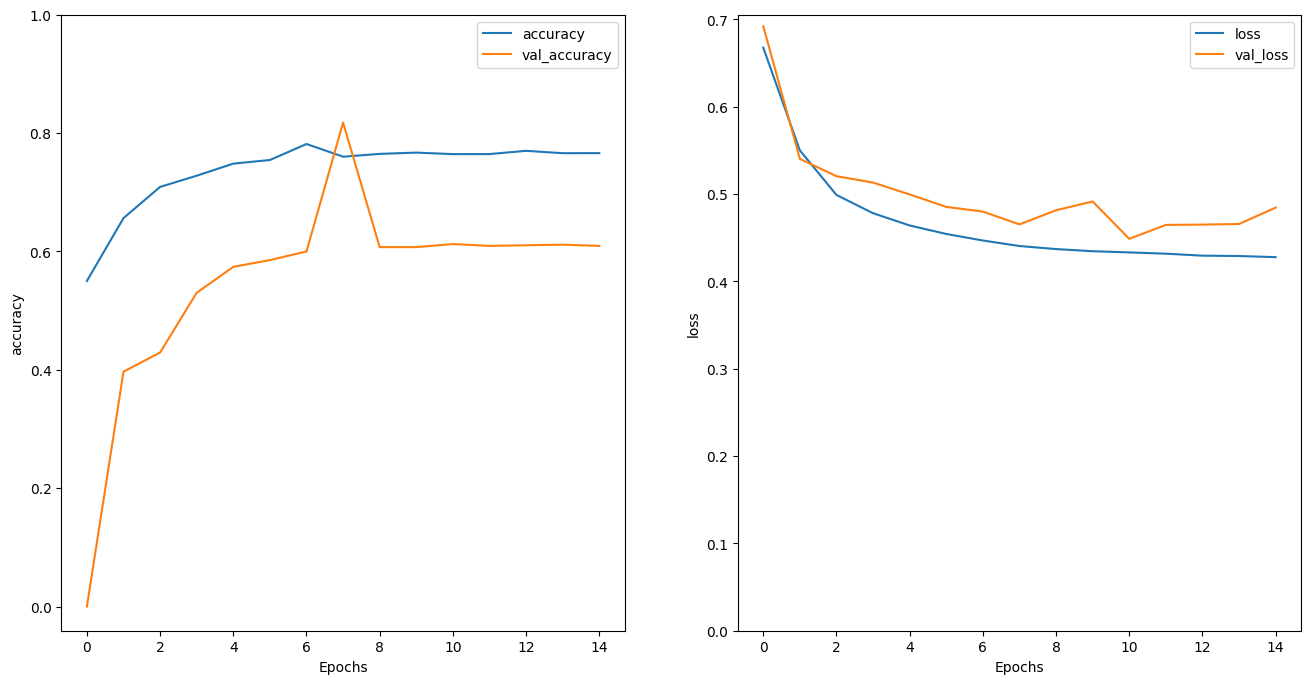

In [29]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [30]:
# predict on a sample text without padding
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[-2.0298734]


##### Experiment 2: Use binary count vectorizer for encoding

In [31]:
model = create_model(encoder_multi_hot)
# predict on a sample formula using untrained model
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 1s 1s/step
[-0.0085412]


In [32]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=["accuracy"])

In [33]:
configs_dict = {
    "learning_rate": 1e-4,
    "algorithm": "BiLstm",
    "configuration": "1-tokens",
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "epochs": 15,
    "batch_size": 64,
    "vectorizer": "multi_hot",
    "dataset": "TOKENIZED_SET_V1"
}
run = wandb.init(project=wandb_project_name, reinit=True, config=configs_dict)


history = model.fit(train_dataset, 
                    epochs=15,
                    validation_data=test_dataset,
                    steps_per_epoch = STEPS_PER_EPOCH,
                    validation_steps = VAL_STEPS_PER_EPOCH,
                    callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/15
156/156 [==============================] - ETA: 0s - loss: 0.6905 - accuracy: 0.5501INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_170705-ajmjcrhx/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_170705-ajmjcrhx/files/model-best/assets


156/156 [==============================] - 30s 165ms/step - loss: 0.6905 - accuracy: 0.5501 - val_loss: 0.7560 - val_accuracy: 0.0000e+00
Epoch 2/15
156/156 [==============================] - 11s 69ms/step - loss: 0.6845 - accuracy: 0.5498 - val_loss: 0.7807 - val_accuracy: 0.0000e+00
Epoch 3/15
156/156 [==============================] - ETA: 0s - loss: 0.6740 - accuracy: 0.5499INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_170705-ajmjcrhx/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_170705-ajmjcrhx/files/model-best/assets


156/156 [==============================] - 25s 160ms/step - loss: 0.6740 - accuracy: 0.5499 - val_loss: 0.7219 - val_accuracy: 0.0000e+00
Epoch 4/15
156/156 [==============================] - 10s 63ms/step - loss: 0.6664 - accuracy: 0.5500 - val_loss: 0.7531 - val_accuracy: 0.0000e+00
Epoch 5/15
156/156 [==============================] - 11s 68ms/step - loss: 0.6595 - accuracy: 0.5552 - val_loss: 0.7223 - val_accuracy: 0.2562
Epoch 6/15
156/156 [==============================] - 10s 62ms/step - loss: 0.6547 - accuracy: 0.5850 - val_loss: 0.7505 - val_accuracy: 0.2562
Epoch 7/15
156/156 [==============================] - 9s 60ms/step - loss: 0.6527 - accuracy: 0.6125 - val_loss: 0.7827 - val_accuracy: 0.2562
Epoch 8/15
156/156 [==============================] - 10s 61ms/step - loss: 0.6522 - accuracy: 0.6158 - val_loss: 0.7619 - val_accuracy: 0.2562
Epoch 9/15
156/156 [==============================] - 10s 61ms/step - loss: 0.6500 - accuracy: 0.6172 - val_loss: 0.8077 - val_accuracy: 0.

In [34]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

15/15 [==============================] - 0s 19ms/step - loss: 0.7590 - accuracy: 0.2562
Test Loss: 0.7589781880378723
Test Accuracy: 0.2562499940395355


(0.0, 0.8251823604106903)

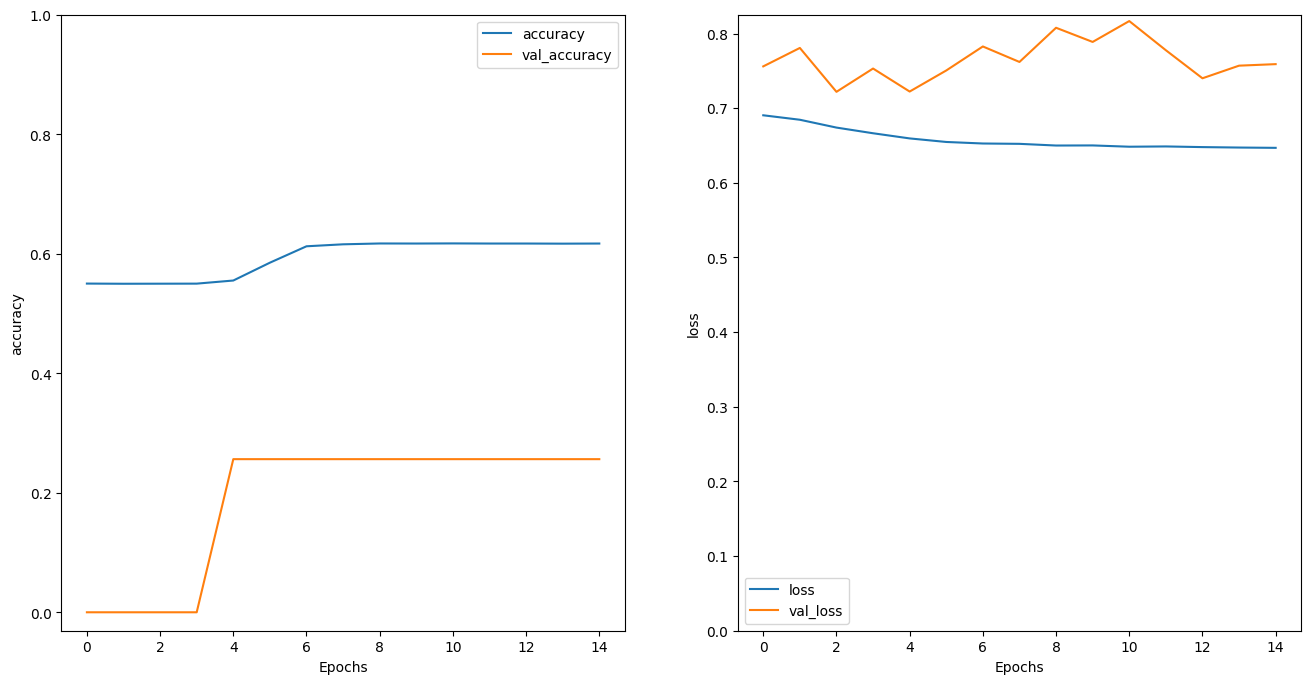

In [35]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [36]:
# predict on a sample text without padding
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 1s 1s/step
[-0.58520484]


##### Experiment 3:

In [37]:
model = create_model(encoder_count)
# predict on a sample formula using untrained model
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 1s 1s/step
[-0.00201415]


In [38]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=["accuracy"])

In [39]:
configs_dict = {
    "learning_rate": 1e-4,
    "algorithm": "BiLstm",
    "configuration": "1-tokens",
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "epochs": 15,
    "batch_size": 64,
    "vectorizer": "count",
    "dataset": "TOKENIZED_SET_V1"
}
run = wandb.init(project=wandb_project_name, reinit=True, config=configs_dict)


history = model.fit(train_dataset, 
                    epochs=15,
                    validation_data=test_dataset,
                    steps_per_epoch = STEPS_PER_EPOCH,
                    validation_steps = VAL_STEPS_PER_EPOCH,
                    callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/15
156/156 [==============================] - ETA: 0s - loss: 0.6893 - accuracy: 0.5501INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_171021-jguc2n3l/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_171021-jguc2n3l/files/model-best/assets


156/156 [==============================] - 30s 158ms/step - loss: 0.6893 - accuracy: 0.5501 - val_loss: 0.7390 - val_accuracy: 0.0000e+00
Epoch 2/15
156/156 [==============================] - 10s 62ms/step - loss: 0.6719 - accuracy: 0.5500 - val_loss: 0.7530 - val_accuracy: 0.0000e+00
Epoch 3/15
156/156 [==============================] - ETA: 0s - loss: 0.6573 - accuracy: 0.5498INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_171021-jguc2n3l/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_171021-jguc2n3l/files/model-best/assets


156/156 [==============================] - 25s 158ms/step - loss: 0.6573 - accuracy: 0.5498 - val_loss: 0.6969 - val_accuracy: 0.0302
Epoch 4/15
156/156 [==============================] - 10s 67ms/step - loss: 0.6499 - accuracy: 0.5610 - val_loss: 0.6973 - val_accuracy: 0.2896
Epoch 5/15
156/156 [==============================] - 10s 64ms/step - loss: 0.6448 - accuracy: 0.6213 - val_loss: 0.7265 - val_accuracy: 0.2865
Epoch 6/15
156/156 [==============================] - 10s 65ms/step - loss: 0.6411 - accuracy: 0.6318 - val_loss: 0.7167 - val_accuracy: 0.2844
Epoch 7/15
156/156 [==============================] - 10s 62ms/step - loss: 0.6383 - accuracy: 0.6308 - val_loss: 0.7484 - val_accuracy: 0.2750
Epoch 8/15
156/156 [==============================] - 10s 62ms/step - loss: 0.6365 - accuracy: 0.6304 - val_loss: 0.7439 - val_accuracy: 0.2812
Epoch 9/15
156/156 [==============================] - 10s 63ms/step - loss: 0.6352 - accuracy: 0.6298 - val_loss: 0.7172 - val_accuracy: 0.2958
Ep

In [40]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

15/15 [==============================] - 0s 24ms/step - loss: 0.7160 - accuracy: 0.2948
Test Loss: 0.7160069346427917
Test Accuracy: 0.29479166865348816


(0.0, 0.7592517256736755)

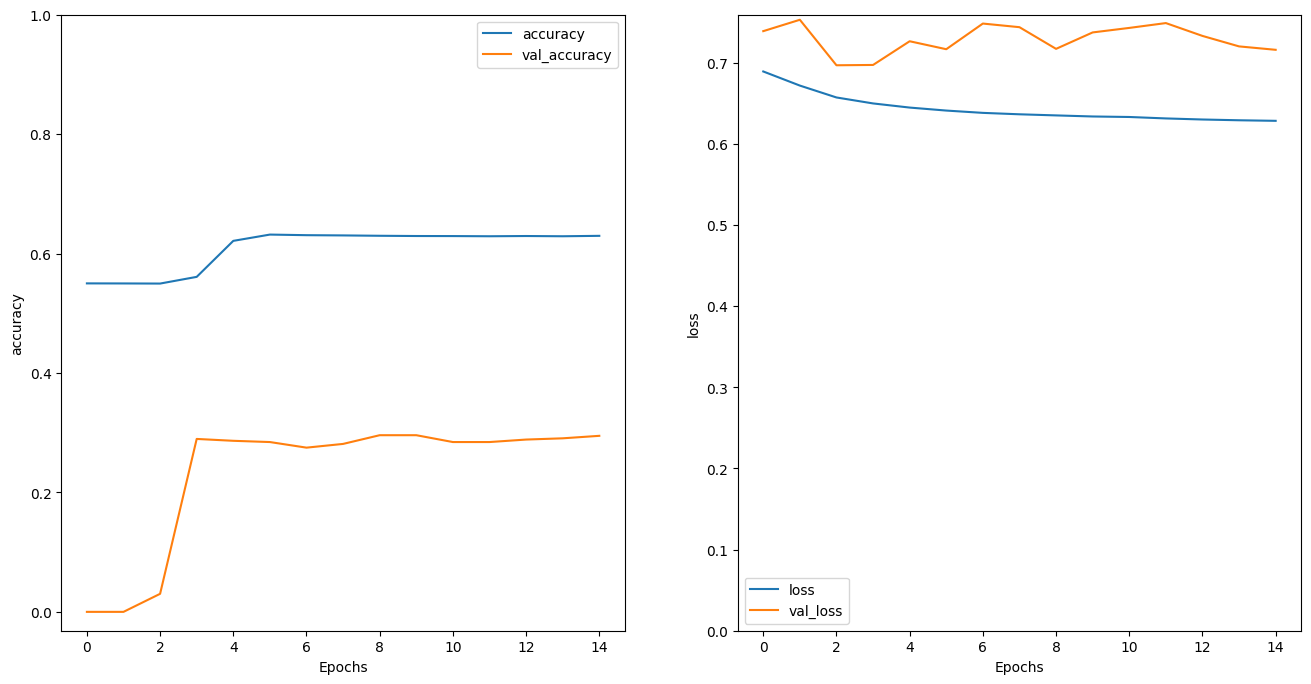

In [41]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [42]:
# predict on a sample text without padding
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[-1.3840569]


##### Experiment 4:

In [43]:
model = create_model(encoder_bigrams)
# predict on a sample formula using untrained model
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 1s 1s/step
[-0.01132661]


In [44]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (TextV  (None, 1000)             0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 1000, 64)          64000     
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 138,369
Trainable params: 138,369
Non-tr

In [45]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=["accuracy"])

In [46]:
configs_dict = {
    "learning_rate": 1e-4,
    "algorithm": "BiLstm",
    "configuration": "1-tokens",
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "epochs": 15,
    "batch_size": 64,
    "vectorizer": "bigram_count",
    "dataset": "TOKENIZED_SET_V1"
}
run = wandb.init(project=wandb_project_name, reinit=True, config=configs_dict)


history = model.fit(train_dataset, 
                    epochs=15,
                    validation_data=test_dataset,
                    steps_per_epoch = STEPS_PER_EPOCH,
                    validation_steps = VAL_STEPS_PER_EPOCH,
                    callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/15
156/156 [==============================] - ETA: 0s - loss: 0.6888 - accuracy: 0.5499INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_171337-hjckmgef/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_171337-hjckmgef/files/model-best/assets


156/156 [==============================] - 102s 627ms/step - loss: 0.6888 - accuracy: 0.5499 - val_loss: 0.7597 - val_accuracy: 0.0000e+00
Epoch 2/15
156/156 [==============================] - ETA: 0s - loss: 0.6665 - accuracy: 0.5501INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_171337-hjckmgef/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_171337-hjckmgef/files/model-best/assets


156/156 [==============================] - 98s 630ms/step - loss: 0.6665 - accuracy: 0.5501 - val_loss: 0.6993 - val_accuracy: 0.0000e+00
Epoch 3/15
156/156 [==============================] - ETA: 0s - loss: 0.6491 - accuracy: 0.5749INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_171337-hjckmgef/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_171337-hjckmgef/files/model-best/assets


156/156 [==============================] - 89s 570ms/step - loss: 0.6491 - accuracy: 0.5749 - val_loss: 0.6979 - val_accuracy: 0.2656
Epoch 4/15
156/156 [==============================] - 74s 472ms/step - loss: 0.6390 - accuracy: 0.6278 - val_loss: 0.7185 - val_accuracy: 0.2583
Epoch 5/15
156/156 [==============================] - 74s 472ms/step - loss: 0.6324 - accuracy: 0.6297 - val_loss: 0.7232 - val_accuracy: 0.2594
Epoch 6/15
156/156 [==============================] - 74s 476ms/step - loss: 0.6294 - accuracy: 0.6290 - val_loss: 0.7388 - val_accuracy: 0.2594
Epoch 7/15
156/156 [==============================] - 75s 480ms/step - loss: 0.6264 - accuracy: 0.6293 - val_loss: 0.7557 - val_accuracy: 0.2573
Epoch 8/15
156/156 [==============================] - 74s 476ms/step - loss: 0.6250 - accuracy: 0.6288 - val_loss: 0.7120 - val_accuracy: 0.2656
Epoch 9/15
156/156 [==============================] - 82s 526ms/step - loss: 0.6233 - accuracy: 0.6307 - val_loss: 0.7248 - val_accuracy: 0.2

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_171337-hjckmgef/files/model-best/assets


156/156 [==============================] - 89s 572ms/step - loss: 0.6217 - accuracy: 0.6294 - val_loss: 0.6919 - val_accuracy: 0.2990
Epoch 12/15
156/156 [==============================] - ETA: 0s - loss: 0.6205 - accuracy: 0.6298INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_171337-hjckmgef/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_171337-hjckmgef/files/model-best/assets


156/156 [==============================] - 90s 579ms/step - loss: 0.6205 - accuracy: 0.6298 - val_loss: 0.6912 - val_accuracy: 0.2990
Epoch 13/15
156/156 [==============================] - 81s 521ms/step - loss: 0.6201 - accuracy: 0.6320 - val_loss: 0.7084 - val_accuracy: 0.2646
Epoch 14/15
156/156 [==============================] - 69s 442ms/step - loss: 0.6193 - accuracy: 0.6298 - val_loss: 0.6915 - val_accuracy: 0.2979
Epoch 15/15
156/156 [==============================] - 72s 461ms/step - loss: 0.6191 - accuracy: 0.6316 - val_loss: 0.7178 - val_accuracy: 0.2604


In [47]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

15/15 [==============================] - 2s 139ms/step - loss: 0.7178 - accuracy: 0.2604
Test Loss: 0.7177892923355103
Test Accuracy: 0.2604166567325592


(0.0, 0.7667637795209885)

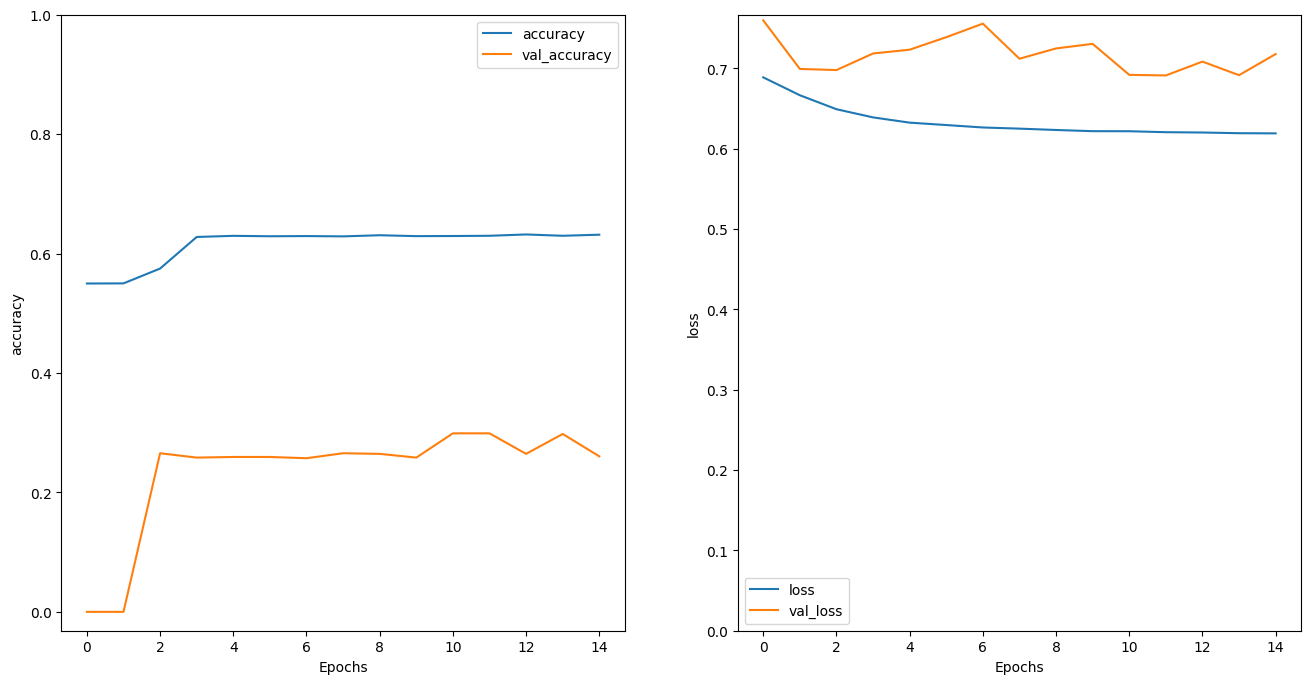

In [48]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [49]:
# predict on a sample text without padding
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[-1.0524367]


##### Experiment 5:

In [50]:
model = create_model(encoder_tf_idf)
# predict on a sample formula using untrained model
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[-0.00906602]


In [51]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=["accuracy"])

In [52]:
configs_dict = {
    "learning_rate": 1e-4,
    "algorithm": "BiLstm",
    "configuration": "1-tokens",
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "epochs": 15,
    "batch_size": 64,
    "vectorizer": "tf_idf",
    "dataset": "TOKENIZED_SET_V1"
}
run = wandb.init(project=wandb_project_name, reinit=True, config=configs_dict)

history = model.fit(train_dataset, 
                    epochs=15,
                    validation_data=test_dataset,
                    steps_per_epoch = STEPS_PER_EPOCH,
                    validation_steps = VAL_STEPS_PER_EPOCH,
                    callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/15
156/156 [==============================] - ETA: 0s - loss: 0.6886 - accuracy: 0.5497INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_173412-z1j9919y/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_173412-z1j9919y/files/model-best/assets


156/156 [==============================] - 35s 194ms/step - loss: 0.6886 - accuracy: 0.5497 - val_loss: 0.7482 - val_accuracy: 0.0000e+00
Epoch 2/15
156/156 [==============================] - ETA: 0s - loss: 0.6752 - accuracy: 0.5497INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_173412-z1j9919y/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_173412-z1j9919y/files/model-best/assets


156/156 [==============================] - 26s 164ms/step - loss: 0.6752 - accuracy: 0.5497 - val_loss: 0.7415 - val_accuracy: 0.0000e+00
Epoch 3/15
156/156 [==============================] - ETA: 0s - loss: 0.6599 - accuracy: 0.5500INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_173412-z1j9919y/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_173412-z1j9919y/files/model-best/assets


156/156 [==============================] - 26s 168ms/step - loss: 0.6599 - accuracy: 0.5500 - val_loss: 0.6950 - val_accuracy: 0.0010
Epoch 4/15
156/156 [==============================] - ETA: 0s - loss: 0.6489 - accuracy: 0.5650INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_173412-z1j9919y/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas/wandb/run-20230305_173412-z1j9919y/files/model-best/assets


156/156 [==============================] - 26s 165ms/step - loss: 0.6489 - accuracy: 0.5650 - val_loss: 0.6882 - val_accuracy: 0.1937
Epoch 5/15
156/156 [==============================] - 9s 58ms/step - loss: 0.6391 - accuracy: 0.6052 - val_loss: 0.7328 - val_accuracy: 0.1990
Epoch 6/15
156/156 [==============================] - 9s 59ms/step - loss: 0.6321 - accuracy: 0.6129 - val_loss: 0.7258 - val_accuracy: 0.2698
Epoch 7/15
156/156 [==============================] - 9s 58ms/step - loss: 0.6262 - accuracy: 0.6278 - val_loss: 0.7422 - val_accuracy: 0.2656
Epoch 8/15
156/156 [==============================] - 9s 58ms/step - loss: 0.6218 - accuracy: 0.6311 - val_loss: 0.7196 - val_accuracy: 0.2906
Epoch 9/15
156/156 [==============================] - 9s 56ms/step - loss: 0.6180 - accuracy: 0.6317 - val_loss: 0.7272 - val_accuracy: 0.2896
Epoch 10/15
156/156 [==============================] - 9s 57ms/step - loss: 0.6144 - accuracy: 0.6335 - val_loss: 0.7117 - val_accuracy: 0.2969
Epoch 1

In [53]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

15/15 [==============================] - 0s 21ms/step - loss: 0.7237 - accuracy: 0.2833
Test Loss: 0.7236614227294922
Test Accuracy: 0.28333333134651184


(0.0, 0.755372378230095)

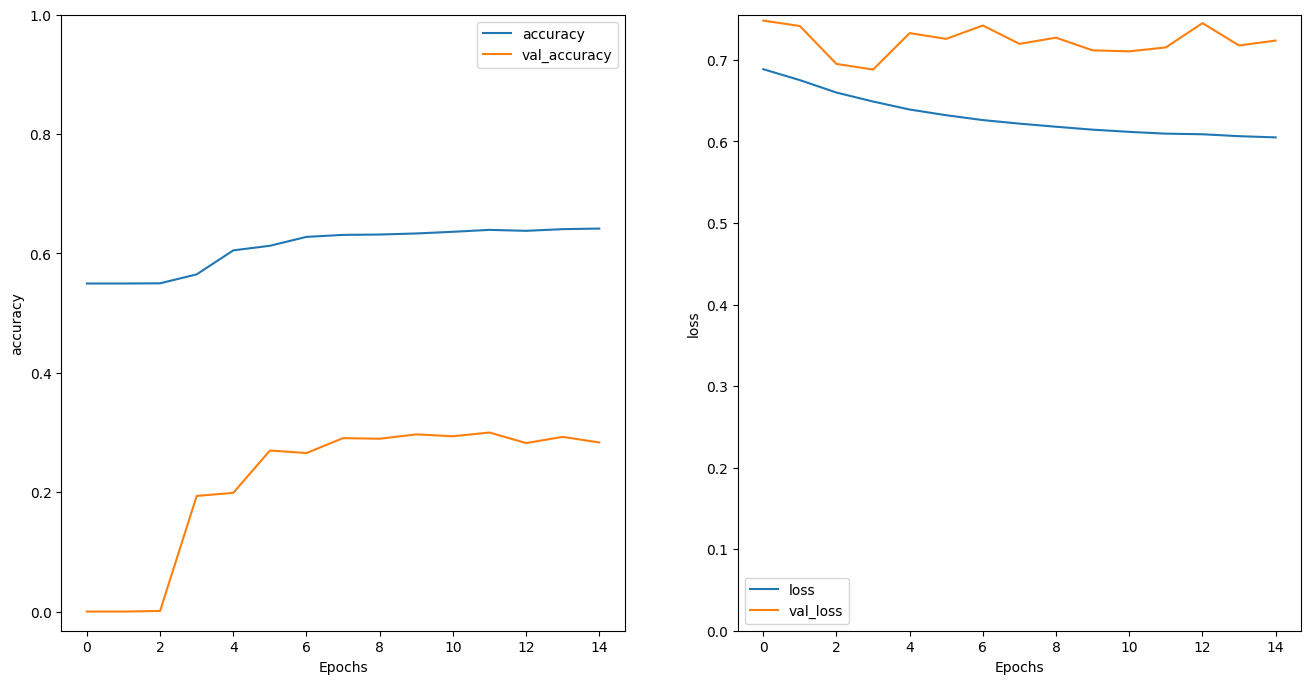

In [54]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [55]:
# predict on a sample text without padding
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[-1.5316707]
